
# <center>Python for data analysis</center>
## <center>Final project | SkillCraft</center>  

------

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA as pca_skl
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

%matplotlib inline

## Description of the dataset  

### Brief presentation
    SkillCraft is a dataset composed of a lot of features of over three thousand players playing at StarCraft 2 from bronze to professionnal gamers. In ower study we will try to predict the league index of a player concidering all his others features. Thus, it is a classification problem.

### Origin of the dataset

    - Creators: Mark Blair, Joe Thompson, Andrew Henrey, Bill Chen 
    - Mark Blair: Department of Psychology; Simon Fraser University; Burnaby; 8888 University Drive; mblair '@' sfu.ca) 
    - Date: September, 20, 2013

### Information given by the creators :

    - We aggregated screen movements into screen-fixations using a Salvucci & Goldberg(2000) dispersion-threshold algorithm, 
      and defined Perception Action Cycles (PACs) as fixations with at least one action.

    - Time is recorded in terms of timestamps in the StarCraft 2 replay file. When the game is played on faster 1 real-time 
      second is equivalent to roughly 88.5 timestamps.

    - List of possible game actions is discussed in Thompson, Blair, Chen, & Henrey (2013)
    
### List of features :

- **GameID**: Unique ID number for each game (integer)
- **LeagueIndex**: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
- **Age**: Age of each player (integer)
-  **HoursPerWeek**: Reported hours spent playing per week (integer)
-  **TotalHours**: Reported total hours spent playing (integer)
-  **APM**: Action per minute (continuous)
-  **SelectByHotkeys**: Number of unit or building selections made using hotkeys per timestamp (continuous)
-  **AssignToHotkeys**: Number of units or buildings assigned to hotkeys per timestamp (continuous)
-  **UniqueHotkeys**: Number of unique hotkeys used per timestamp (continuous)
-  **MinimapAttacks**: Number of attack actions on minimap per timestamp (continuous)
-  **MinimapRightClicks**: number of right-clicks on minimap per timestamp (continuous)
-  **NumberOfPACs**: Number of PACs per timestamp (continuous)
-  **GapBetweenPACs**: Mean duration in milliseconds between PACs (continuous)
-  **ActionLatency**: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
-  **ActionsInPAC**: Mean number of actions within each PAC (continuous)
-  **TotalMapExplored**: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
-  **WorkersMade**: Number of SCVs, drones, and probes trained per timestamp (continuous)
-  **UniqueUnitsMade**: Unique unites made per timestamp (continuous)
-  **ComplexUnitsMade**: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
-  **ComplexAbilitiesUsed**: Abilities requiring specific targeting instructions used per timestamp (continuous)  


# Data Exploration

## First step

### Import data

In [11]:
dataset = pd.read_csv("SkillCraft1_Dataset.csv", index_col="GameID")
dataset.sort_index(inplace=True)
dataset.head()
print("Shape : ", dataset.shape)

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,,,,,,,,,,,,,,,,,,,
52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Shape :  (3395, 19)


### Have a look on the types of the columns

In [12]:
dataset.dtypes

LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

- We see here that some variables are continuous and others are discret. **Age**, **HoursPerWeek** and **TotalHours** are detected as Object but they are numeric values. Let's parse them to numeric.

In [17]:
#By using errors = 'coerce', we give the value NaN to the not numeric values instead of throwing an exception.
for col in ['Age', 'HoursPerWeek', 'TotalHours']:
    dataset[col] = pd.to_numeric(dataset[col], errors = 'coerce')

### Quality of values

- Good, now all the columns are well defined, we now want to see **if there are missing datas** and see how we can deal with it (Delete the columns ? The observations ? Give a default value (mean of the column) ?)  

    So let's have a look on missed values (NaN/NA/0/...)

In [18]:
dataset.isnull().sum()

LeagueIndex              0
Age                     57
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

- We can see that **Age** contains 55 NaN values, **HoursPerWeek** contains 56 NaN values and **TotalHours** 57 NaN values.  
    Let's check this.

In [35]:
dataset[dataset['Age'].isnull()].head(3)
dataset[dataset['Age'].isnull()].tail(3)

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,,,,,,,,,,,,,,,,,,,
1064,5,NaN,20.0,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
5255,5,NaN,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338
10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000


,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,,,,,,,,,,,,,,,,,,,
10092,8,NaN,NaN,NaN,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
10094,8,NaN,NaN,NaN,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
10095,8,NaN,NaN,NaN,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


- We can replace these values by the mean of the concerned features. Indeed we are in a classification problem and delete these rows could delete a class of our target.

In [235]:
# Get the concerned columns
columns_to_modify = missed_value_count.index[missed_value_count>0]

# Replace with the mean
for col in columns_to_modify:
    mean = dataset[col][dataset[col] != '?'].astype(int).mean()
    dataset[col].replace("?", int(mean), inplace=True)

# Update columns type
dataset = dataset.astype({'Age':int, 'HoursPerWeek':int, 'TotalHours':int} )

### Check if all is good

In [236]:
dataset[dataset=='?'].count()

LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [237]:
dataset.dtypes

LeagueIndex               int64
Age                       int32
HoursPerWeek              int32
TotalHours                int32
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

- Alright ! We are ready to start !

### Check the range / mean / std... of each features

In [238]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
LeagueIndex,3395.0,4.184094,1.517327,1.000000,3.000000,4.000000,5.000000,8.000000
Age,3395.0,21.637408,4.172921,16.000000,19.000000,21.000000,24.000000,44.000000
HoursPerWeek,3395.0,15.895729,11.864377,0.000000,8.000000,12.000000,20.000000,168.000000
TotalHours,3395.0,960.414728,17172.094828,3.000000,300.000000,500.000000,800.000000,1000000.000000
APM,3395.0,117.046947,51.945291,22.059600,79.900200,108.010200,142.790400,389.831400
SelectByHotkeys,3395.0,0.004299,0.005284,0.000000,0.001258,0.002500,0.005133,0.043088
AssignToHotkeys,3395.0,0.000374,0.000225,0.000000,0.000204,0.000353,0.000499,0.001752
UniqueHotkeys,3395.0,4.364654,2.360333,0.000000,3.000000,4.000000,6.000000,10.000000
MinimapAttacks,3395.0,0.000098,0.000166,0.000000,0.000000,0.000040,0.000119,0.003019
MinimapRightClicks,3395.0,0.000387,0.000377,0.000000,0.000140,0.000281,0.000514,0.004041


- We can see that our target LeagueIndex is an int between 1 (beginner) and 8 (professional). Thus a middle player would have a league index of 4.  
    But the most important here is the TotalHours and HoursPerWeek features, a player seems to have passed 1,000,000 hours on the game and another play 24/24! We have to check these features.

- First, TotalHours :

In [239]:
dataset.sort_values('TotalHours', ascending=False)

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,,,,,,,,,,,,,,,,,,,
5140,5,18,24,1000000,281.4246,0.023428,0.000799,5,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29,0.001328,6,0.000000,0.000000
6518,6,20,8,25000,247.0164,0.015794,0.000438,8,0.000308,0.001339,0.004645,17.6471,37.1837,6.5944,29,0.001860,6,0.000000,0.000012
2246,5,22,16,20000,248.0490,0.023703,0.000391,7,0.000000,0.000205,0.004651,37.8795,45.3760,4.7560,21,0.001526,6,0.000000,0.000000
5610,4,22,10,18000,152.2374,0.011983,0.000206,1,0.000016,0.000364,0.003351,52.1896,63.9811,4.9575,19,0.000680,5,0.000000,0.000000
6242,3,24,20,10260,76.5852,0.000780,0.000197,0,0.000063,0.000316,0.002438,42.9480,84.6340,5.9107,27,0.000450,10,0.000246,0.000358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,4,19,2,10,55.9674,0.000820,0.000315,1,0.000011,0.000045,0.003000,64.8271,83.0562,3.3296,15,0.000562,7,0.000000,0.000112
979,2,16,10,10,32.6730,0.001263,0.000111,0,0.000019,0.000056,0.001244,95.8788,119.1642,4.1493,10,0.000854,3,0.000000,0.000000
4320,2,16,10,10,44.9700,0.001562,0.000134,4,0.000000,0.000000,0.001741,156.6234,110.6154,3.8462,18,0.000647,5,0.000000,0.000000


It seems to be the only weird value for this feature. Indeed 25,000 hours is about 3 years and it is possible for a 20 years old player. So let's remove the player with the 5140 GameID. 

In [240]:
dataset.drop(index=5140, inplace=True)

- Then, HoursPerWeek :

In [241]:
dataset.sort_values('HoursPerWeek', ascending=False)

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,,,,,,,,,,,,,,,,,,,
2000,6,16,168,1260,233.3058,0.017521,0.000744,10,0.000178,0.000235,0.005137,25.5962,38.9165,5.0961,43,0.001027,10,0.000315,0.000502
4817,6,21,140,1800,197.7774,0.006001,0.000383,4,0.000308,0.001307,0.004445,29.9962,42.8764,7.0019,32,0.001365,11,0.000058,0.000350
3733,6,24,112,1500,139.7598,0.005748,0.000368,4,0.000213,0.000155,0.005011,24.6822,41.8956,4.1489,28,0.000756,5,0.000000,0.000000
4754,7,18,98,700,236.0316,0.015664,0.001015,10,0.000366,0.001632,0.006487,18.7787,29.9871,4.3371,25,0.001507,8,0.000000,0.000000
7435,4,34,96,400,56.8584,0.000059,0.000029,1,0.000029,0.000265,0.001530,47.6078,129.8462,6.9038,11,0.000765,5,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7836,4,21,2,255,84.5652,0.001757,0.000286,4,0.000016,0.000556,0.003424,54.0383,75.8759,4.1551,34,0.001087,10,0.000155,0.000188
6545,5,28,2,200,60.7074,0.001067,0.000243,6,0.000112,0.000393,0.002453,72.6462,84.0000,4.1298,20,0.000637,5,0.000000,0.000000
9141,6,24,2,730,121.4622,0.007075,0.000511,5,0.000000,0.000274,0.003993,41.1009,55.3790,3.9087,14,0.000766,6,0.000000,0.000036


- The second hight value is 140 hours per week which means 4h to sleep and eat. It is crazy but possible... So let's just remove the game with 2000 GameID

In [242]:
dataset.drop(index=2000, inplace=True)

## Overview plots

### Histogramm

- Let's have a look on the distribution of each features

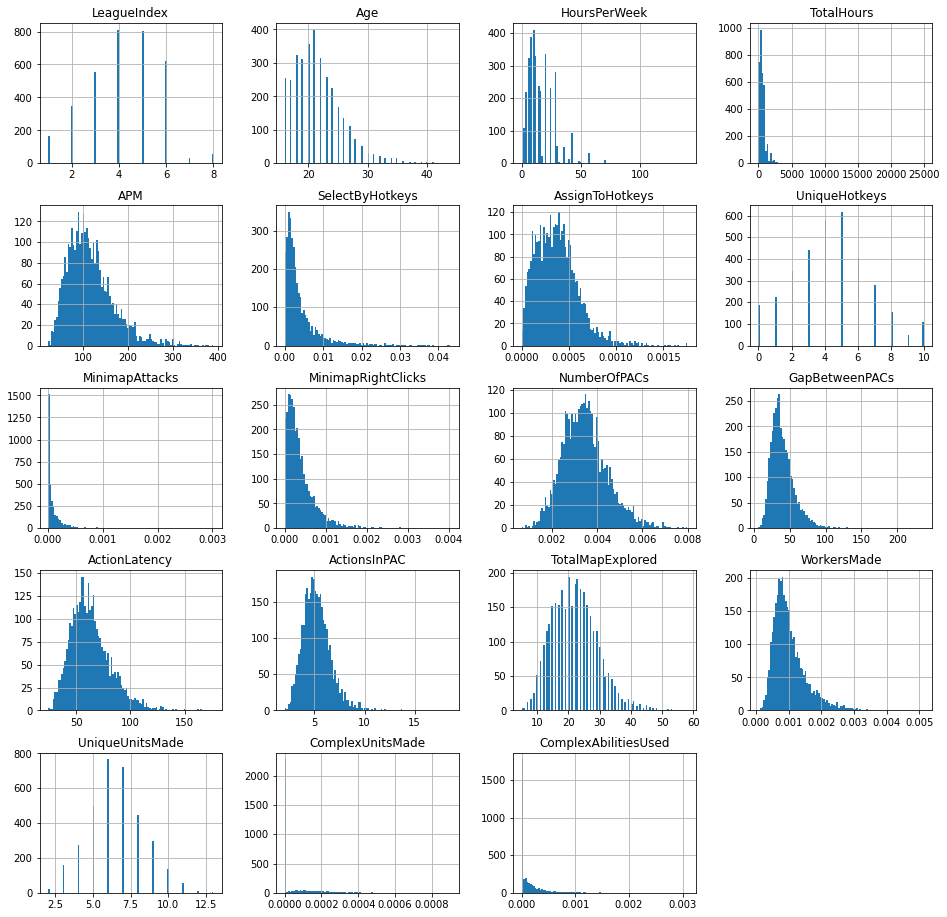

In [243]:
dataset.hist(bins=100, figsize=(16, 16));

- It seems to have a lot of player having a level between 1 and 6, then the number drops sharply. When we see these splot it seems important to normalize and centralize the data. Moreover the major part of the features have a normal or poisson distribution (so maybe a log transformation is a good idea for some features). We will it when we will split our data in train and test dataset.

    *Note that if we stil have really height value with a feature we would see it directly because his histogramm would be stock on the left side (like a bar at 0). It is the case for MinimapAttacks but we lack of information about this feature and we don't know if it is normal or not..*

### Correlation matrix

- A good idea now would be to check the correlation between each features.

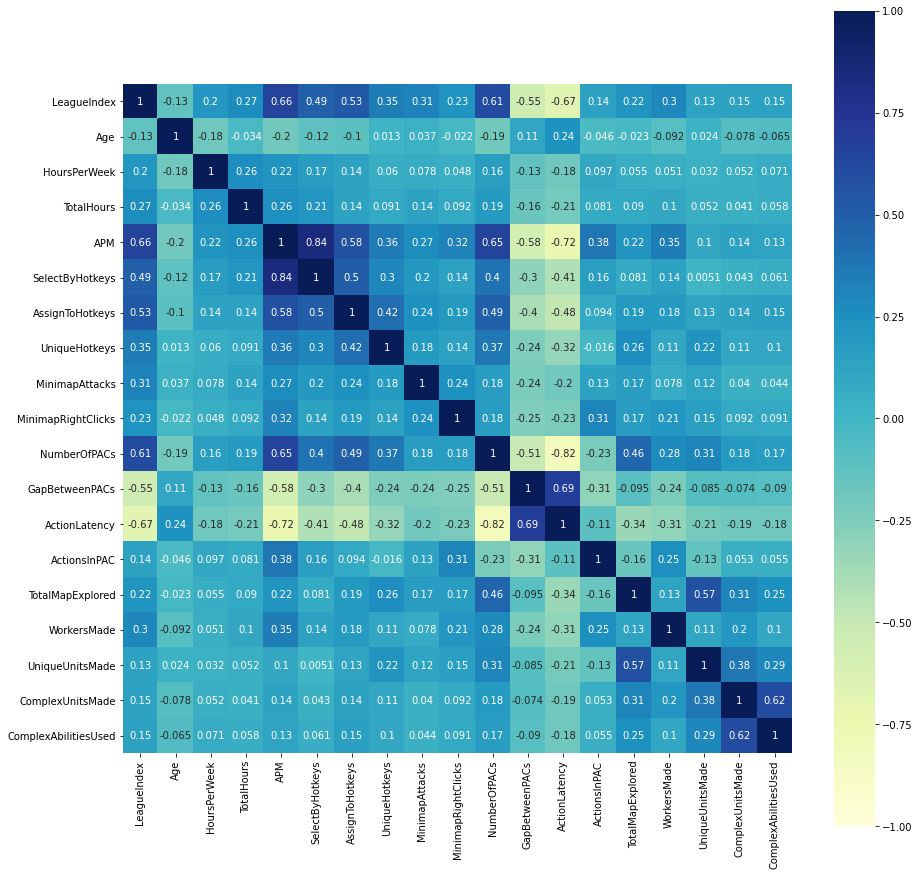

In [244]:
plt.figure(figsize=(15,15))
sns.heatmap(dataset.corr(),
            vmin=-1, vmax=1,
            cmap='YlGnBu',
            annot=True, 
            square=True);

- Here we could expect that Age and the League index are correlated but, it is not the case and it seems to have good player among the young and old ! We see that it is the more technical features which are the most predictive of player's level, like APM which is hight for hight level or Action latency which will be very quick with the best players. We also have GapBetweenPACs, and AssignToHotkeys which are good predictive features.

    So, we progressively dress the typical profil of a good player : low latency, quick reaction, use the hotkeys to select their units (which is also correlated to the reaction) etc... 

### KDE of interesting features

- So, let's have a look on some of the features we have seen before

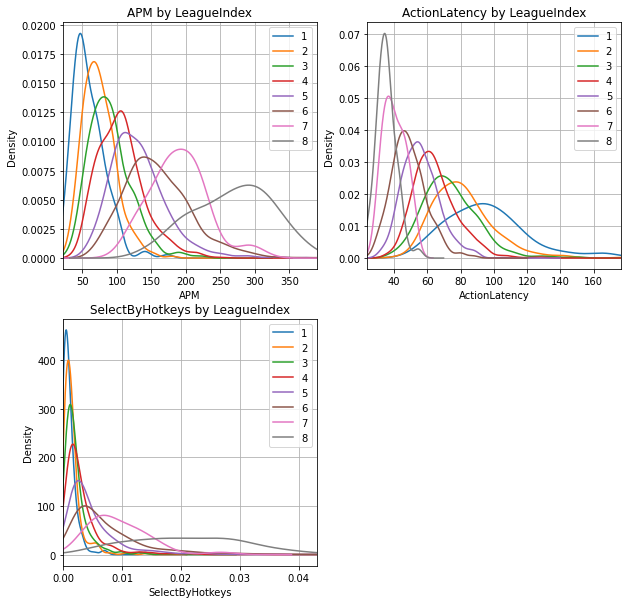

In [245]:
for k, feature in enumerate(['APM', 'ActionLatency', 'SelectByHotkeys']):
    plt.subplot(2, 2, k+1);
    dataset.groupby('LeagueIndex')[feature].plot.kde(legend=True, 
                                                     figsize=(10, 10),
                                                    xlim=(min(dataset[feature]), 
                                                          max(dataset[feature])),
                                                    ylabel="Density",
                                                    grid=True,
                                                    title=f"{feature} by LeagueIndex");
    plt.xlabel(feature);
plt.show();

- For the two first plots (APM and League Index) the means for each league index are well separate and comfort the idea that it is good features to predict the player's level. However SelectByHotkeys seems to be a good predictor only for the best player. It means that the player having a score between 0 and 6 don't use hot key but when we have a level at 7 or 8 we must improve all our techniques and use hot keys can be an axe of improvment.

### Scatter matrix

- So let's take som of our previous features, plot them and color the observation with the league index 

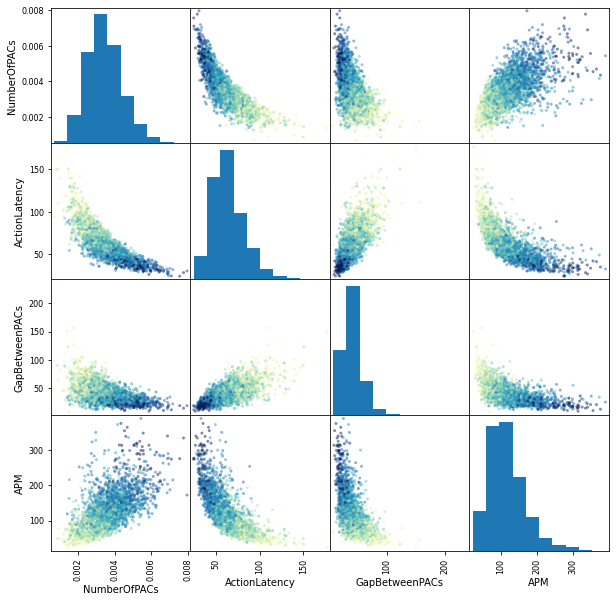

In [246]:
interesting_features = ['NumberOfPACs', 'ActionLatency', 'GapBetweenPACs', 'APM']

pd.plotting.scatter_matrix(dataset[interesting_features], 
                           c=dataset['LeagueIndex'],
                           cmap='YlGnBu',
                           figsize=(10, 10),
                           label=dataset['LeagueIndex']);

It's great ! We see here that the league index evolves progressivly with the value of the feature. It means that our favorite features are predictive !

## Data Prepocessing

### Data engineering

- First, add some features

In [247]:
columns_to_transform = ['TotalHours']
for col in columns_to_transform:
    dataset[f"log({col})"] = np.log(dataset[col])

In [248]:
dataset

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,log(TotalHours)
GameID,,,,,,,,,,,,,,,,,,,,
52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000,8.006368
55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.000000,0.000208,8.517193
56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189,5.298317
57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384,5.991465
58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019,6.214608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,8,21,15,960,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000,6.866933
10090,8,21,15,960,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000,6.866933
10092,8,21,15,960,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000,6.866933


### Split in train and test set

- First, let's split the dataset and shuffle it

In [249]:
X = dataset.drop(['LeagueIndex'], axis=1).to_numpy()
Y = dataset['LeagueIndex'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.3)

print('X:', X_train.shape, X_test.shape)
print('Y:', y_train.shape, y_test.shape)

X: (2375, 19) (1018, 19)
Y: (2375,) (1018,)


### Normalize data

In [250]:
scl = sk.preprocessing.StandardScaler()

X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)

## Modeling

### Logistic Regression

In [251]:
clf = sk.linear_model.LogisticRegression(random_state=42, max_iter=1000, fit_intercept=True)
clf.fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

LogisticRegression(max_iter=1000, random_state=42)

0.4449901768172888

### RandomForest

In [252]:
clf = RandomForestClassifier(n_estimators=10000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

RandomForestClassifier(n_estimators=10000)

0.4351669941060904

## Validation

### PCA

In [227]:
def make_PCA(X_test, y_test, y_pred):

    colors = ['blue', 'green', 'red', 'orange', 'brown', 'purple', 'yellow', 'black']
    
    #Apply PCA
    projected_xi = (pca_skl(n_components=2)
                    .fit_transform(X_test))

    data = {'predict':{k+1: projected_xi[y_pred == k+1] for k in range(8)},
            'real':{k+1: projected_xi[y_test == k+1] for k in range(8)}}
    
    success = {True:projected_xi[y_pred == y_test], 
               False:projected_xi[y_pred != y_test]}
        
    #Plot on factorial plan
    plt.figure(figsize=(15, 20))
    plt.subplot(2, 1, 1)

    for k in range(len(data['real'])):
        x_predict = np.asarray(data['predict'][k+1])[:, 0]
        y_predict = np.asarray(data['predict'][k+1])[:, 1]
        
        x_real = np.asarray(data['real'][k+1])[:, 0]
        y_real = np.asarray(data['real'][k+1])[:, 1]

        plt.scatter(x_predict, y_predict,
                    alpha=0.6,
                    s=5,
                    color=colors[k],
                    label='predict'+str(list(data['predict'].keys())[k]))
        
        plt.scatter(x_real, y_real,
                    alpha=0.2,
                    s=5*8,
                    color=colors[k],
                    label='real'+str(list(data['real'].keys())[k]))
    plt.legend()
    plt.title("Compare real and predicted labels")
    
    plt.subplot(2, 1, 2)
    for state in (True, False):
        x = np.asarray(success[state])[:, 0]
        y = np.asarray(success[state])[:, 1]
        plt.scatter(x, y,
                    alpha=0.6,
                    s=20,
                    color='green' if state else 'red',
                    label='Correct' if state else 'Uncorrect')
    plt.legend()
    plt.title("Correctand uncorrect predicted labels")
    
    plt.show()

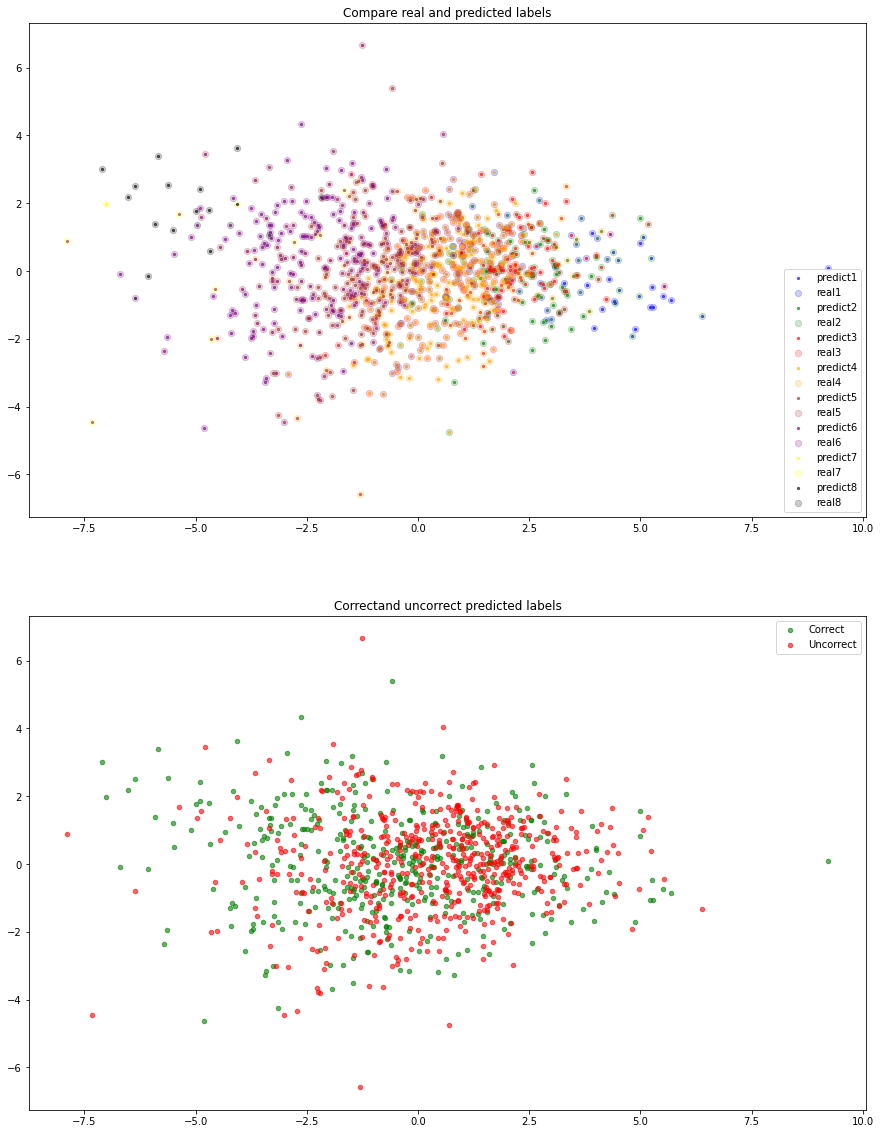

In [228]:
make_PCA(X_test_scaled, y_test, clf.predict(X_test_scaled))